# Corona
### Investigate how Corona performs on montecarlo data


to use:     
1) fetch my (github/abotas) icaro WalkthroughCorona    
2) fetch my IC-1 branch corona.     
3) source manage.sh work_in_blah_blah 3.6   
4) download pmap and dst file for a run    
5) make sure you have IC_DATA and ICARO in your path
6) run

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib  .pyplot  as     plt
from   matplotlib  .patches import Ellipse
from   mpl_toolkits.mplot3d import Axes3D

import invisible_cities.core.fit_functions      as fitf
from   invisible_cities.database                import load_db
from   invisible_cities.core.core_functions     import in_range, rebin_array
from   invisible_cities.core.system_of_units_c  import units
from   invisible_cities.reco.pmaps_functions    import load_pmaps, integrate_charge, plot_s2si_map#, select_si_slice
from   invisible_cities.reco.tbl_functions      import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms      import barycenter, corona

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from   icaro.core.kdst_functions   import load_dst, event_rate, profile_and_fit, print_fit, chi2
#from   detector_response_functions import gather_montecarlo_hits
import invisible_cities.core.fit_functions as fitf

source = 'Kr' # str of Co, Na, or Kr

In [2]:
run_number = 0
DataSensor = load_db.DataSiPM()
dxs = DataSensor.X.values
dys = DataSensor.Y.values

In [3]:
sub_run    = '0'
ic_data = os.path.join(os.environ['IC_DATA'])
pmap_paths = {'Co': ic_data + '/Montecarlo/ir_co170419/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run),
              'Na': ic_data + '/Montecarlo/na170426_ir/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run),
              'Kr': ic_data + '/Montecarlo/kr_ir170330/dst_NEXT_v0_08_09_Kr_ACTIVE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run)
             }

In [4]:
# CORONA PARAMS
Qthr           =  0*units.pes
Qlm            = 10*units.pes
lm_radius      = 15*units.mm
new_lm_radius  = 25*units.mm
msipm          =  3

#### Functions used in other branches not yet integrated into nextic/master

In [5]:
def select_si_slice(si, slice_no):
    # This is a temporary fix! The number of slices in the SiPM arrays
    # must match that of the PMT PMaps.
    return {sipm_no: (sipm[slice_no] if len(sipm) > slice_no else 0)
                      for sipm_no, sipm in si.items()}
def gather_montecarlo_hits(filepath):
    """
    gather_montecarlo_hits gathers all the hits from a pytable in filepath and
    puts them in a dictionary. The dictionary maps event index to the hits in
    that event.
    args
    filepath: the path to an input file
    returns
    file_hits: a dictionary mapping event_indx, named by nexus -->
               hits_ev, a np.array with all the hits in event event_indx
               hits_ev has shape (num hits, 4) and can by index as follows:
               hits_ev[hit, x coordinate, y coordinate, z coordinate, energy]
               and file_hits[ev] = hits_ev
    """
    with tb.open_file(filepath, 'r') as f:
        ptab   = f.root.MC.MCTracks
        hits_f = {}
        ev     = ptab[0]['event_indx']
        s_row  = 0

        # Iterate over the rows in the pytable; each row contains a distinct hit
        for row in ptab.iterrows():

            # We want to gather the hits event by event so, here we check
            # for a change in event_indx to signal start of new event
            # * 'or row.nrow == ptab.nrows - 1' needed to gather hits from last
            # * event in the file
            if ev != row['event_indx'] or row.nrow == ptab.nrows - 1:

                # Find start and finish rows (hits) in previous event
                if row.nrow == ptab.nrows - 1: f_row = row.nrow + 1
                else: f_row = row.nrow
                hits_ev = np.empty((f_row - s_row, 4), dtype=np.float32)
                # Get extract hit position and energy from pytable
                hits_ev[:, :3] = ptab[s_row : f_row]['hit_position'] * units.mm
                hits_ev[:,  3] = ptab[s_row : f_row]['hit_energy'  ] * units.MeV
                hits_f[ev]     = hits_ev  # put hits for ev in the hits_f dict
                ev    = row['event_indx'] # update ev
                s_row = row.nrow          # update start row for ev

    return hits_f

### Load pmap file, which contains pmaps but also MCTracks since this is montecarlo

In [6]:
pmap_path = pmap_paths[source]
with tb.open_file(pmap_path, 'r') as f: 
    nevents = len(f.root.Run.events)
    print(f)

/Users/alej/Desktop/IC_DATA//Montecarlo/kr_ir170330/dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_pmaps_10000.root.h5 (File) ''
Last modif.: 'Wed May  3 17:45:29 2017'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/MCTracks (Table(69606,), shuffle, zlib(4)) 'MCTracks'
/PMAPS (Group) ''
/PMAPS/S1 (Table(62944,), shuffle, zlib(4)) 'S1 Table'
/PMAPS/S2 (Table(90673,), shuffle, zlib(4)) 'S2 Table'
/PMAPS/S2Si (Table(414569,), shuffle, zlib(4)) 'S2Si Table'
/Run (Group) ''
/Run/events (Table(9999,), shuffle, zlib(4)) 'event info table'
/Run/runInfo (Table(9999,), shuffle, zlib(4)) 'run info table'



#### PMAP

In [7]:
S1s, S2s, S2Sis = load_pmaps(pmap_path)
ns1s = 0
ns2s = 0
for s1k in S1s: ns1s += len(S1s[s1k])
for s2k in S2s: ns2s += len(S2s[s2k])
print('N events                         :', nevents)
print('N S1s, S2s                       :', ns1s, ns2s)
print('N events with at least one S1, S2:', len(S1s), len(S2s))

N events                         : 9999
N S1s, S2s                       : 9443 10023
N events with at least one S1, S2: 9437 9984


#### A quick look at S2s

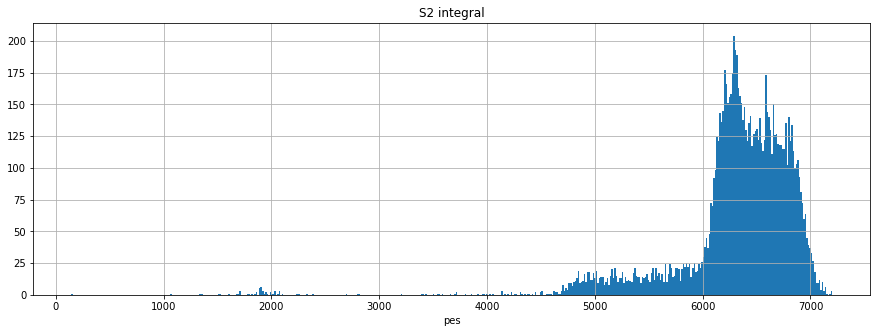

In [8]:
S2e = []
for k in S2s:
    for peak in S2s[k]:
        S2e.append(S2s[k][peak][1].sum())
plt.figure(figsize=(15,5))
plt.hist(S2e, bins = len(S2s) // 20)
plt.grid(True)
plt.xlabel('pes')
plt.title('S2 integral')
plt.show()

A bunch of plot functions

In [9]:
# A method in HitCollectionCity
def compute_xy_position(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    
    
    xs, ys  = dxs[IDs], dys[IDs]
    return corona(np.array([xs, ys]).T, np.array(Qs), new_lm_radius=new_lm_radius, Qlm=Qlm, msipm=msipm)

def plot_helper(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    xs, ys  = dxs[IDs], dys[IDs]
    return xs, ys, Qs

# plot a 48x48 SiPM map
def plot_test_slice(l_X,l_Y,l_Q, min_alpha=0):
    """
    Plots a SiPM map in the NEW Geometry
    """
    l_Q = np.array(l_Q)
    if l_Q.min() > 0: Q = l_Q - l_Q.min()
    else            : Q = np.copy(l_Q)
    Q = Q / Q.max()
    
    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(5.0)
    fig.set_figwidth(5.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,Q):
        r = Ellipse(xy=(xx, yy), width=4., height=4.);
        r.set_facecolor('0');
        r.set_alpha(min_alpha + qq * (1 - min_alpha));
        ax1.add_artist(r);

    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    return ax1

        
def plot_corona_tbin(ax, clusters):
    # Plot corona clusters
    for c in clusters: 
        e=Ellipse(xy=(c.pos[0],c.pos[1]), width=2*nsig*c.rms[0], height=2*nsig*c.rms[1])
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(min(.8, c.Q / 200.0*units.pes))
        e.set_facecolor('red')
        
def plot_event_clusters(ECs, zs, figsize=(30,30)):
    fig = plt.figure(figsize=figsize)
    
    xs = []
    ys = []
    qs = []
    xrms = []
    yrms = []
    for i in range(len(ECs)):
        for C in ECs[i]:
            xs.append(C.pos[0])
            ys.append(C.pos[1])
            #zs.append(zrange[i])
            qs.append(C.Q)
            xrms.append(C.rms[0])
            yrms.append(C.rms[1])
   
    xs = np.array(xs); ys = np.array(ys);  qs = np.array(qs); 

    reds  = qs / qs.max()
    color = np.zeros((len(reds),3),dtype=np.float32)
    color[:,0] = reds
    ax = fig.add_subplot(211, projection='3d')
    s1=ax.scatter(zs, xs, ys, c=color,
                   vmin=0,
                   vmax=color.max(),
                   s=200, #np.pi*((np.array(xrms) + np.array(yrms)) / 2)**2,
                   edgecolors='None', alpha=1)
    ax.set_xlabel('z (microseconds)')
    ax.set_ylabel('x (mm)')
    ax.set_zlabel('y (mm)')
    ax.grid(True)
    return ax


def plot_nexus_event_hits(ax, hits):
    c = hits[:,3] / hits[:,3].max()
    ax.scatter(hits[:,2], hits[:,0], hits[:,1], 
                  c=c, cmap=plt.get_cmap('rainbow'),
                  vmin=0, vmax=c.max(),
                  s=100, edgecolors='None')
    

### Take a look at a specific event

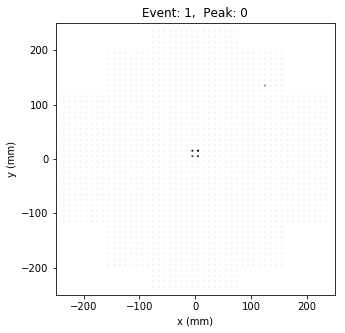

I tried to pick a more interesting looking event


In [10]:
# PICK AN EVENT
event_numbers, timestamps = get_event_numbers_and_timestamps(pmap_path)
if source == 'Kr': event_number = event_numbers[1]
if source == 'Na': event_number = event_numbers[322]
#if source == 'Co': event_number = event_numbers[4]
if source == 'Co': event_number = event_numbers[992]

# PICK A PEAK
peak=0
event_time   = timestamps[np.where(event_numbers==event_number)[0]]

xs   = DataSensor.X.values
ys   = DataSensor.Y.values
Qpk  = np.zeros(len(xs))
for sipm, E in S2Sis[event_number][peak].items(): Qpk[sipm] = E.sum()
plot_test_slice(xs,ys,Qpk, min_alpha=.05)
    
plt.title('Event: ' + str(event_number) + ',  Peak: ' + str(peak))
plt.show()
print('I tried to pick a more interesting looking event')

## Use corona (via compute_xy_position) to get the clusters for each slice

In [11]:
def rebin_S2Si(S2Si, stride):
    """ rebin an S2Si, discards last """
    rS2Si = {}
    for peak in S2Si:
        rS2Si[peak] = {}
        for sipm, E in S2Si[peak].items():
            rS2Si[peak][sipm] = rebin_array(E, stride)
    return rS2Si

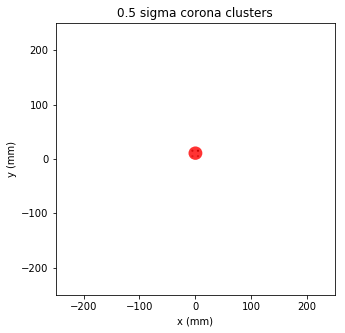

In [12]:
S1 = S1s  .get(event_number, {})
S2 = S2s  .get(event_number, {})
Si = S2Sis.get(event_number, {})

# MUST ADDRESS:
# 1) What times / zcoords to assign to squashed time slices
#    For now just average times of original time slices (div by dV for Z)
#    Probably better to have average weighted by total energy of time slice
# 2) What to do when n_slices % stride != 0. 
#    Now remainder slices are discarded. Not sure what should be done....               
integrate_peak = True  # Squash all time slices
n_slices        = len(Si[peak][next(iter(Si[peak]))])    
if integrate_peak: stride = n_slices
else             : stride = 1
clusters_evt = [[] for i in range(n_slices // stride)]
rSi   = rebin_S2Si(Si, stride)
times = rebin_array(S2[peak][0], stride) / stride 
drift_velocity = units.mm / units.mus
zs    = (times - S1[0][0].mean()) * drift_velocity
nsig  =  1/2 # plot param
# For each tbin, compute clusters, plot SiPMS, plot corona clusters
for slice_no in range(n_slices // stride):
    clusters_evt.append(compute_xy_position(rSi[peak], slice_no))
    ax = plot_test_slice(*plot_helper(rSi[peak], slice_no))
    plot_corona_tbin(ax, clusters_evt[-1])
    plt.title(str(nsig) + ' sigma corona clusters')
    plt.show()


Make sure to look at values along axes to see if plot is reasonable


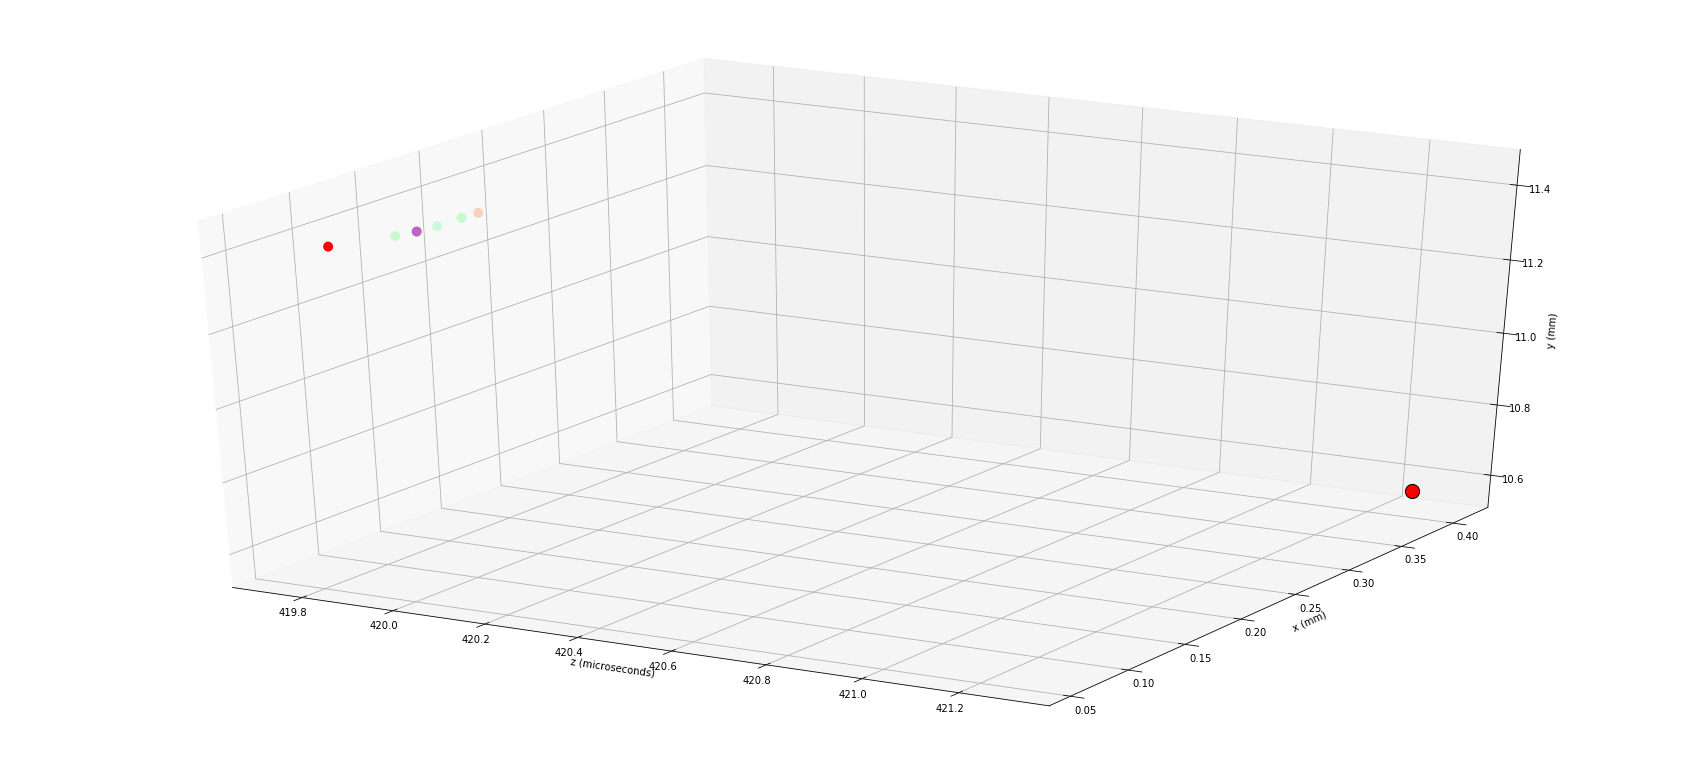

In [13]:
print('Make sure to look at values along axes to see if plot is reasonable')
ax = plot_event_clusters(clusters_evt, zs, figsize=(30,30))
plot_nexus_event_hits(ax, gather_montecarlo_hits(pmap_path)[event_number])
plt.show()

In [14]:
event_numbers, timestamps = get_event_numbers_and_timestamps(pmap_path)
clusters_f = {}
ZS = {}
for event_number in event_numbers:
    S1 = S1s  .get(event_number, {})
    S2 = S2s  .get(event_number, {})
    Si = S2Sis.get(event_number, {})
    
    # Only keep events with one S1, one S2, and one S2Si
    if len(S2) != 1 or len(S1) != 1 or len(Si) != 1: continue 


    # MUST ADDRESS:
    # 1) What times / zcoords to assign to squashed time slices
    #    For now just average times of original time slices (div by dV for Z)
    #    Probably better to have average weighted by total energy of time slice
    # 2) What to do when n_slices % stride != 0. 
    #    Now remainder slices are discarded. Not sure what should be done....       
    integrate_peak  = True   # Squash all time slices
    peak     = list(S2.keys())[0]
    s1k      = list(S1.keys())[0]
    n_slices = len(Si[peak][next(iter(Si[peak]))])
    
    if integrate_peak: stride = n_slices
    else             : stride = 1
        
    clusters_evt = []
    rSi   = rebin_S2Si(Si, stride)
    times = rebin_array(S2[peak][0], stride) / stride # VERY CRUDE
    drift_velocity = units.mm / units.mus
    
    # drift time starts at time of S1!
    zs = (times - S1[list(S1.keys())[0]][0].mean()) * drift_velocity
    ZS[event_number] = zs

    # For each tbin, compute clusters, plot SiPMS, plot corona clusters
    for slice_no in range(n_slices // stride):
        clusters_evt.append(compute_xy_position(rSi[peak], slice_no))
    
    clusters_f[event_number] = clusters_evt

    
# clusters_f
# is a dictionary where the keys are event numbers 
# pointing to a list of the list of clusters in each 
# (potentially rebinned) time bin.

How many clusters are found in thing single integrated time slice

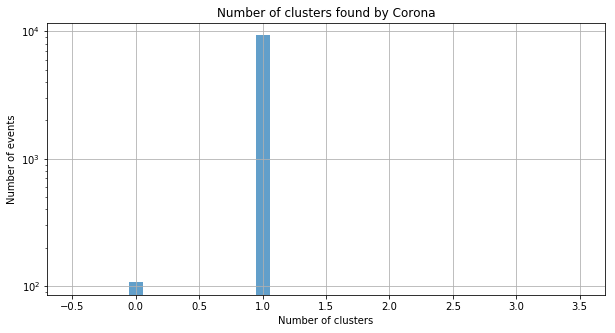

In [15]:
plt.figure(figsize=(10,5))
num_clusters = np.array([len(clusters[0]) for clusters in clusters_f.values()])
plt.hist(num_clusters, bins=36, range=(-.5, 3.5), alpha=.7)
plt.title('Number of clusters found by Corona')
plt.xlabel('Number of clusters')
plt.ylabel('Number of events')
plt.yscale('log')
plt.grid(True)
plt.show()

#### Find truth

In [16]:
# Make dict mapping event number to its barycenter
mclust = {}
for evt, hits in gather_montecarlo_hits(pmap_path).items(): 
    mclust[evt] = barycenter(hits[:,:3], hits[:,3])

#### Find error for squashed events with one cluster

In [17]:
xerr = {}
yerr = {}
zerr = {}
xyd = {}
dist = {}

for event, clusters in clusters_f.items():
    if len(clusters[0]) == 1 and len(clusters) == 1 and event in mclust:
        rc0 = clusters[0][0]
        xerr[event] = rc0.pos[0]   - mclust[event].pos[0]
        yerr[event] = rc0.pos[1]   - mclust[event].pos[1]
        zerr[event] = ZS[event][0] - mclust[event].pos[2]
        
        xyd [event] = np.sqrt(xerr[event]**2 + yerr[event]**2)
        dist[event] = np.sqrt(xerr[event]**2 + yerr[event]**2 + zerr[event]**2)      

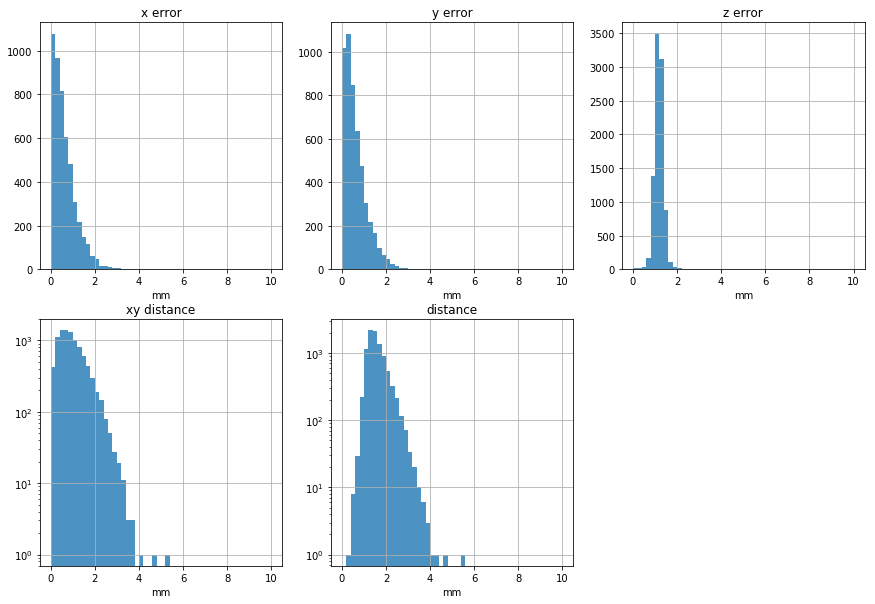

In [18]:
bins = 50
xrg = 0, 10
fig = plt.figure(figsize=(20,10))

fig.add_subplot(241)
plt.hist(list(xerr.values()), bins=bins, alpha=.8, range=xrg)
plt.title('x error')
plt.xlabel('mm')
plt.grid(True)

fig.add_subplot(242)
plt.hist(list(yerr.values()), bins=bins, alpha=.8, range=xrg)
plt.title('y error')
plt.xlabel('mm')
plt.grid(True)

fig.add_subplot(243)
plt.hist(list(zerr.values()), bins=bins, alpha=.8, range=xrg)
plt.title('z error')
plt.xlabel('mm')
plt.grid(True)

fig.add_subplot(245)
plt.hist(list(xyd.values()), bins=bins, alpha=.8, range=xrg)
plt.title('xy distance')
plt.xlabel('mm')
plt.yscale('log')
plt.grid(True)

fig.add_subplot(246)
plt.hist(list(dist.values()), bins=bins, alpha=.8, range=xrg)
plt.title('distance')
plt.xlabel('mm')
plt.yscale('log')
plt.grid(True)

plt.show()

[  1.07422941e+03   4.64906557e-02   6.92797638e-01]


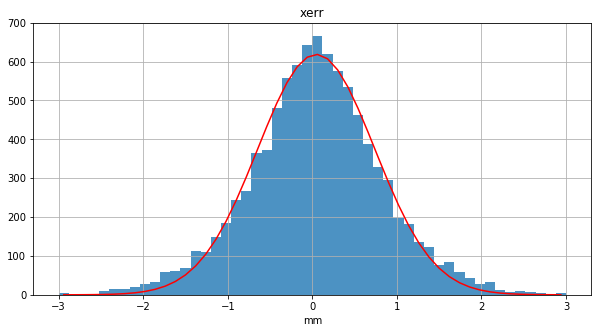

[  1.08119066e+03   6.70813494e-02   7.02739075e-01]


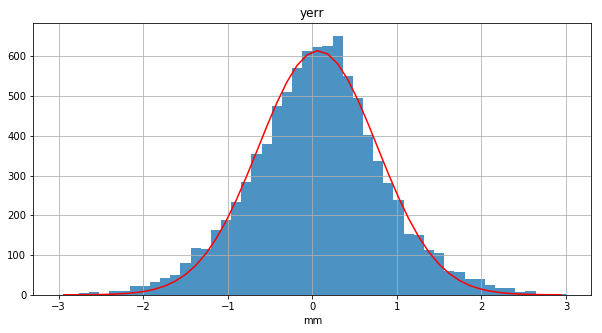

In [19]:
xrg = -3, 3
plt.figure(figsize=(10,5))
plt.title('xerr')
plt.xlabel('mm')
y, x, _ = \
plt.hist(list(xerr.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
print(f.values)

plt.grid(True)
plt.show()
plt.figure(figsize=(10,5))
y, x, _ = \
plt.hist(list(yerr.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
print(f.values)
plt.grid(True)
plt.title('yerr')
plt.xlabel('mm')
plt.show()